In [36]:
import os
import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

In [37]:
"""
loads and merges metadata from the ProstateX dataset, cleaning entries and parsing lesion coordinates
"""
# ==== CONFIGURATION ====
DICOM_ROOT = r"C:\Users\anude\Downloads\project"
FINDINGS_CSV = os.path.join(DICOM_ROOT, "ProstateX-Findings-Train100.csv")
IMAGES_CSV = os.path.join(DICOM_ROOT, "ProstateX-Images-Train100.csv")

# ==== LOAD METADATA ====
findings_df = pd.read_csv(FINDINGS_CSV)
images_df = pd.read_csv(IMAGES_CSV)

# Clean and parse 'ijk' column
images_df = images_df.dropna(subset=["ijk"])
images_df["ijk"] = images_df["ijk"].apply(lambda x: tuple(map(int, str(x).split())))

# Merge findings with image metadata
merged_df = pd.merge(findings_df, images_df, on=["ProxID", "fid"])
merged_df = merged_df.dropna(subset=["ijk", "DCMSerDescr", "ClinSig"])

# ==== FILTER FOR MODALITIES ====
modality_keywords = {
    "T2": ["t2", "t2w"],
    "ADC": ["adc"],
    "DWI": ["dwi", "diffusion", "ep2d_diff", "ep2d"]
}

In [38]:
#Functions

def modality_match(desc, keywords):
    """
    Checks if any of the given keywords are present in the desc string.
    """
    return any(kw.lower() in desc.lower() for kw in keywords)

# ==== IMAGE LOADING ====
def load_slice(proxid, descr_list, slice_idx):
    """
    Searches for a DICOM series under a patient's folder (proxid) matching any description in descr_list, 
    Returns the pixel array of the DICOM file.
    """
    path = os.path.join(DICOM_ROOT, proxid)
    for root, dirs, files in os.walk(path):
        for descr in descr_list:
            if descr.lower() in root.lower():
                dcm_files = sorted([f for f in os.listdir(root) if f.endswith(".dcm")])
                if 0 <= slice_idx < len(dcm_files):
                    dcm_path = os.path.join(root, dcm_files[slice_idx])
                    try:
                        ds = pydicom.dcmread(dcm_path)
                        return ds.pixel_array
                    except Exception as e:
                        print(f"Error reading {dcm_path}: {e}")
                        return None
    return None



Process each lesion entry, loading and resizing slices for all required modalities at the lesion's k index.
Valid samples with all modalities are stacked into 3-channel images and stored with their corresponding clinical significance labels.

In [40]:

# ==== PREPARE SAMPLES ====
samples = []
labels = []

grouped = merged_df.groupby(["ProxID", "fid"])
for _, row in tqdm(merged_df.iterrows(), total=len(merged_df), desc="Loading images"):
    proxid = row["ProxID"]
    ijk = row["ijk"]
    label = row["ClinSig"]

    img_stack = []
    valid = True
    missing_modalities = []
    for mod in modality_keywords:
        img = load_slice(proxid, modality_keywords[mod], ijk[2])
        if img is None:
            missing_modalities.append(mod)
            valid = False
            break
        from skimage.transform import resize
        img_resized = resize(img, (128, 128), mode='reflect', preserve_range=True, anti_aliasing=True)
        img_stack.append(img_resized)

    
    if not valid:
        #print(f"[WARN] Missing modalities for {proxid} fid {row['fid']} at slice {ijk[2]}: {missing_modalities}")
        continue

    # Stack modalities into 3-channel image
    stacked = np.stack(img_stack)
    samples.append(stacked)
    label = row["ClinSig"]
    labels.append(int(label))



Loading images: 100%|██████████| 1577/1577 [00:35<00:00, 44.45it/s]


Converts the image samples and labels into PyTorch tensors, ensuring the input tensor X has the correct shape (N, 3, H, W) for 2D CNNs.

In [42]:

X = torch.tensor(np.array(samples)).float()
y = torch.tensor(labels).long()

print("X shape:", X.shape)  # Add this line to inspect shape

# Ensure X has shape (N, 3, H, W)
if X.ndim != 4 or X.shape[1] != 3:
    raise ValueError(f"Unexpected input shape: {X.shape}. Expected shape (N, 3, H, W).")

X shape: torch.Size([1523, 3, 128, 128])


A simple CNN for binary classification of prostate lesion slices,and trains it using a class-balanced cross-entropy loss.

In [44]:


# define the model
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(32 * (X.shape[2] // 4) * (X.shape[3] // 4), 64), nn.ReLU(),
    nn.Linear(64, 2)
)


# ==== TRAINING ====
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
train_ds, val_ds = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=np.array(labels))
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

from collections import Counter
print("Label distribution:", Counter(labels))

for epoch in range(30):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for xb, yb in pbar:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

torch.save(model.state_dict(), "lesion_classifier.pt")


Label distribution: Counter({0: 1228, 1: 295})


Epoch 30: 100%|██████████| 77/77 [00:00<00:00, 259.42it/s]


Loads the saved CNN model and evaluates it on the validation set, computing precision, recall, F1 score, and accuracy. 

In [46]:

# ==== EVALUATION ====
model.load_state_dict(torch.load("lesion_classifier.pt"))
model.to(device)

model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_true.extend(yb.numpy())

precision = precision_score(all_true, all_preds, zero_division=0)
recall = recall_score(all_true, all_preds, zero_division=0)
f1 = f1_score(all_true, all_preds, zero_division=0)
accuracy = accuracy_score(all_true, all_preds)

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")
print(f"Accuracy:  {accuracy:.2f}")


Precision: 0.72
Recall:    0.70
F1 Score:  0.71
Accuracy:  0.87


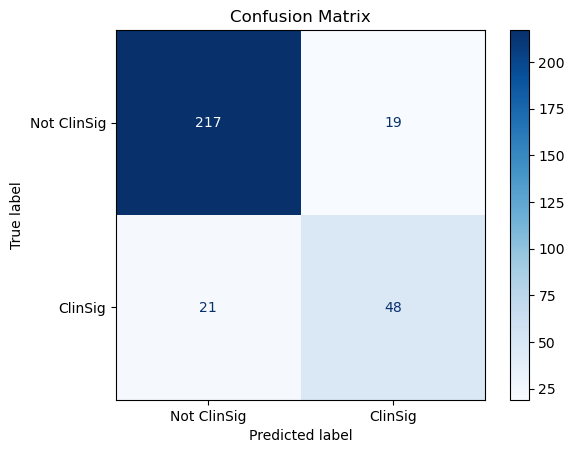


=== Sample Predictions ===
Prediction: Not ClinSig | Actual: Not ClinSig
Prediction: Not ClinSig | Actual: Not ClinSig
Prediction: ClinSig | Actual: ClinSig
Prediction: Not ClinSig | Actual: Not ClinSig
Prediction: Not ClinSig | Actual: Not ClinSig
Prediction: Not ClinSig | Actual: Not ClinSig
Prediction: ClinSig | Actual: Not ClinSig
Prediction: ClinSig | Actual: ClinSig
Prediction: ClinSig | Actual: Not ClinSig
Prediction: ClinSig | Actual: ClinSig


In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

# === CONFUSION MATRIX ===
cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not ClinSig", "ClinSig"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

# === SAMPLE PREDICTIONS ===
print("\n=== Sample Predictions ===")
sample_indices = random.sample(range(len(all_true)), 10)
for idx in sample_indices:
    pred = all_preds[idx]
    actual = all_true[idx]
    print(f"Prediction: {'ClinSig' if pred == 1 else 'Not ClinSig'} | Actual: {'ClinSig' if actual == 1 else 'Not ClinSig'}")



=== Sample Predictions with Modality Slices (T2, ADC, DWI) ===


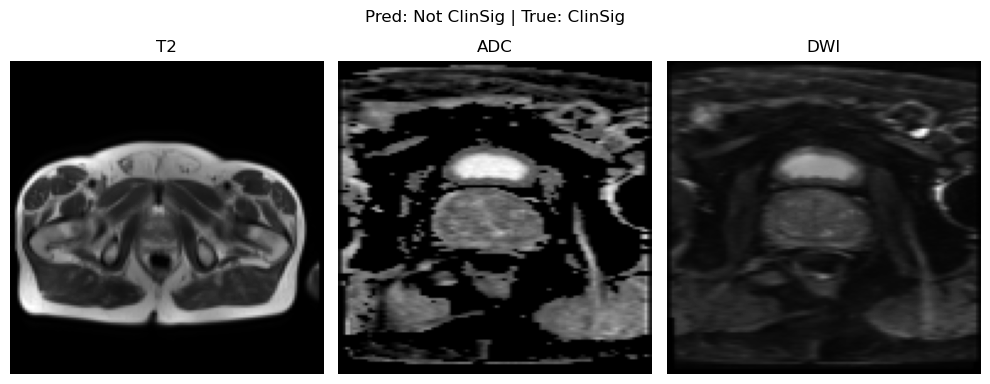

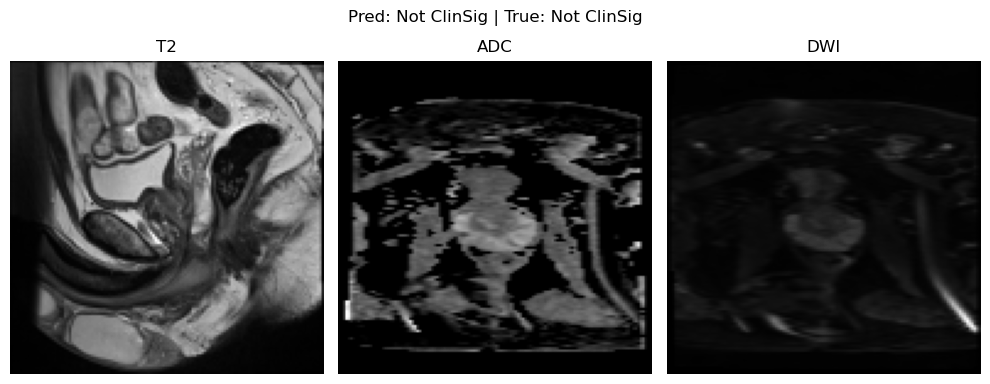

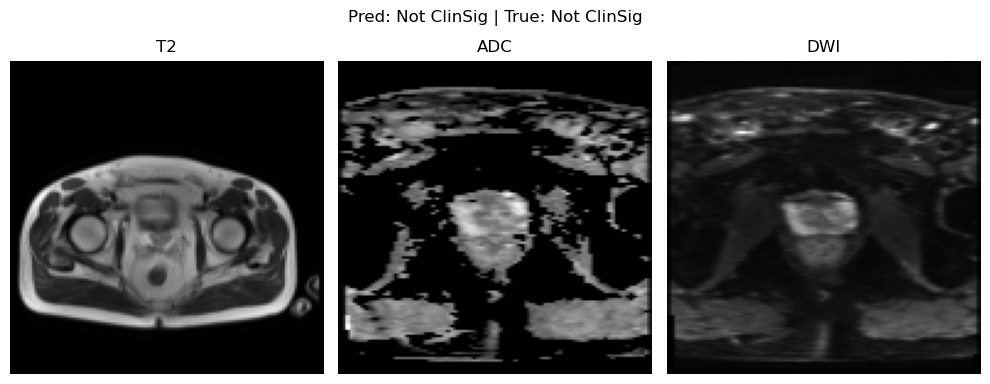

In [48]:
import matplotlib.pyplot as plt

# === SAMPLE PREDICTIONS WITH 3 MODALITY GREYSCALE IMAGES ===
print("\n=== Sample Predictions with Modality Slices (T2, ADC, DWI) ===")
modality_names = ['T2', 'ADC', 'DWI']

sample_indices = random.sample(range(len(all_true)), 3)

for idx in sample_indices:
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    pred = all_preds[idx]
    actual = all_true[idx]

    for i in range(3):
        img = X[idx, i].numpy()  # (H, W)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(modality_names[i])

    plt.suptitle(f"Pred: {'ClinSig' if pred == 1 else 'Not ClinSig'} | True: {'ClinSig' if actual == 1 else 'Not ClinSig'}")
    plt.tight_layout()
    plt.show()
